## Softmax Function
- https://www.jianshu.com/p/cb93d5e39bca

In [2]:
import numpy as np
def softmax_function(x):
    return np.exp(x) / np.sum(np.exp(x))


y = np.array([0.8,0.5,0.7,0.6,0.9,1.5])

softmax_function(y)


array([0.15189927, 0.11252975, 0.13744415, 0.12436461, 0.16787466,
       0.30588757])

In [4]:
import numpy as np
def softmax_function_with_temperature(x, temperature):
    return np.exp(x/temperature) / np.sum(np.exp(x/temperature))

softmax_function_with_temperature(y,10)

array([0.16602326, 0.16111653, 0.1643713 , 0.16273578, 0.16769182,
       0.17806131])

In [5]:
softmax_function_with_temperature(y,0.5)

array([0.12027232, 0.06600685, 0.09847065, 0.08062095, 0.14690094,
       0.4877283 ])

## Time Series Analysis in Python
- https://www.kaggle.com/rakannimer/air-passenger-prediction
- https://github.com/ywchiu/cdc_course/blob/master/slides/20180724%20-%20R%20%E8%AA%9E%E8%A8%80%E8%88%87%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92(%E4%B8%83).pdf

## Normal Distribution

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  # This is added back by InteractiveShellApp.init_path()


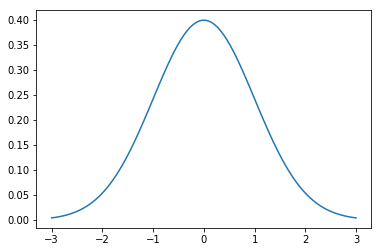

In [7]:
% pylab inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.mlab as mlab
import math

mu       = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x,mlab.normpdf(x, mu, sigma))
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  


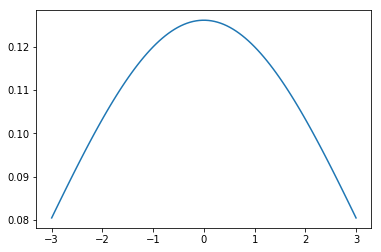

In [9]:
mu       = 0
variance = 10
sigma = math.sqrt(variance)
#x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
x = np.linspace(mu - 3, mu + 3, 100)
plt.plot(x,mlab.normpdf(x, mu, sigma))
plt.show()

## 使用VAE 生成圖片

### 引用套件

In [51]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

from   scipy.stats import norm
import matplotlib.image as matimg
import glob

from keras.datasets import mnist
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives

### 設定網路參數

In [52]:
##math.sqrt(12288)

In [82]:
#num_training_examples = 1200
#num_testing_examples  = 125
num_training_examples = 171
num_testing_examples  = 32

#batch_size   = 25
batch_size   = 5
original_dim = 64 * 64 * 3 #this is same as image_vector_size
latent_dim   = 2
intermediate_dim = 256
epsilon_std  = 1.0

### 讀取圖片

In [83]:
def load_image(path):
    img = matimg.imread(path)
    return img

#following code loads data from local repo
#directory should have two subfolders, with name train and test
def load_local_data(path):
    paths = glob.glob(os.path.join(path + "/train", "*.jpg"))
    X_train = np.array( [ load_image(p) for p in paths ] )

    paths = glob.glob(os.path.join(path + "/test", "*.jpg"))
    X_test = np.array( [ load_image(p) for p in paths ] )
   
    return X_train, X_test

### 建立 Encoder

In [84]:
x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean    = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

### 取樣函數

In [85]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

### 建立解碼器

In [86]:
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h    = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded    = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

### 計算 VAE 損失

#### KL Divergence
- https://zh.wikipedia.org/wiki/%E7%9B%B8%E5%AF%B9%E7%86%B5

In [87]:
# modified calculation of loss
def vae_loss(x, x_decoded_mean):
    #xent_loss = reconstruction error
    xent_loss = original_dim * objectives.binary_crossentropy(x, x_decoded_mean)
    
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

### 建立 VAE 模型

In [88]:

# vae model# vae mo 
vae = Model(x, x_decoded_mean)
vae.compile(optimizer='rmsprop', loss=vae_loss)

# if want to train with data from local repo
path="idol_face_vae"
(x_train, x_test) = load_local_data(path)
print(x_train.shape)

x_train = x_train.astype('float32') / 255.
x_test  = x_test.astype('float32')  / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test  = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))



(171, 64, 64, 3)


In [89]:
x_train.shape

(171, 12288)

In [90]:
x_test.shape

(32, 12288)

In [91]:
#to train the model

vae.fit(x_train, x_train,
        shuffle=True,
        nb_epoch=50,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys


Train on 171 samples, validate on 32 samples
Epoch 1/50
170/171 [============================>.] - ETA: 0s - loss: 9140.2746

InvalidArgumentError: Matrix size-incompatible: In[0]: [1,256], In[1]: [5,2]
	 [[Node: training_3/RMSprop/gradients/dense_28/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:CPU:0"](dense_26/Relu, training_3/RMSprop/gradients/AddN_3)]]

### HDF5
- https://support.hdfgroup.org/HDF5/

In [34]:
vae.save_weights('vae_landscape_100.h5')

In [36]:
vae.load_weights('vae_landscape_100.h5')

### 產生生成器

In [37]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)

# build a face generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded      = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

### 圖片生成

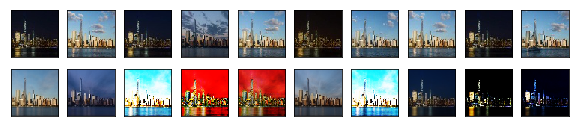

In [45]:
img_size = 64

# following values can generate some good skyline images
samples_encoded = [[5.55, -3.33], [-1.11, 10], [120, 13.3], [33.33, -77.77], [11.11, -33.33], [11.11, 11.11], [100, -33.33], [-7.77, -1.11], [-33.33, -11.11], [-33.33, 11.11]]
samples         = x_test[15:25]


# code to create a result.png with generated faces
plt.figure(figsize=(10, 2))

for i, yi in enumerate(samples_encoded):
    z_sample = np.array([[yi[0], yi[1]]])
    x_decoded = generator.predict(z_sample)
    x_decoded = x_decoded
    #print x_decoded.shape
    face = x_decoded[0].reshape(img_size, img_size, 3)


    ax1 = plt.subplot(2, 10, i + 1)
    plt.imshow(samples[i].reshape(img_size, img_size, 3))
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)

    ax = plt.subplot(2, 10, i + 10 + 1)
    plt.imshow(face)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)



plt.savefig('result.png')
#plt.show()

## CelebA
- http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

## RNN

In [93]:
import pandas
df = pandas.read_csv('https://raw.githubusercontent.com/ywchiu/tibamedl/master/Data/2330.TW.csv')

In [94]:
df = df[~ df['Close'].isna()]

In [95]:
df.count()

Date         1851
Open         1851
High         1851
Low          1851
Close        1851
Adj Close    1851
Volume       1851
dtype: int64

In [96]:
trainset = df.iloc[0:1551,:]
testset  = df.iloc[1551: ,:]

In [97]:
training_set = trainset[~ trainset['Close'].isna()].iloc[:, 4:5].values

In [98]:
test_set = testset[~ testset['Close'].isna()].iloc[:, 4:5].values

In [101]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [102]:
import numpy as np
X_train = []
y_train = []
for i in range(60, len(training_set)):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [103]:
import numpy as np
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [104]:
# Importing the Keras libraries and packages
from keras.models import Sequential 
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising the RNN
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True)) 
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True)) 
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

In [106]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 10, batch_size = 100)

Epoch 1/10
1491/1491 [==============================] - 5s 3ms/step - loss: 0.0066
Epoch 2/10
1491/1491 [==============================] - 2s 2ms/step - loss: 0.0033
Epoch 3/10
1491/1491 [==============================] - 2s 1ms/step - loss: 0.0031
Epoch 4/10
1491/1491 [==============================] - 2s 2ms/step - loss: 0.0031
Epoch 5/10
1491/1491 [==============================] - 2s 1ms/step - loss: 0.0031
Epoch 6/10
1491/1491 [==============================] - 2s 1ms/step - loss: 0.0028
Epoch 7/10
1491/1491 [==============================] - 2s 2ms/step - loss: 0.0029
Epoch 8/10
1491/1491 [==============================] - 2s 1ms/step - loss: 0.0028
Epoch 9/10
1491/1491 [==============================] - 2s 1ms/step - loss: 0.0028
Epoch 10/10
1491/1491 [==============================] - 2s 2ms/step - loss: 0.0024


In [110]:
real_stock_price = trainset.iloc[:,4:5].values

In [112]:
real_stock_price.shape

(1551, 1)

In [113]:
predicted_stock_price = regressor.predict(X_train)

In [115]:
predicted_stock_price.shape

(1491, 1)

In [116]:
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

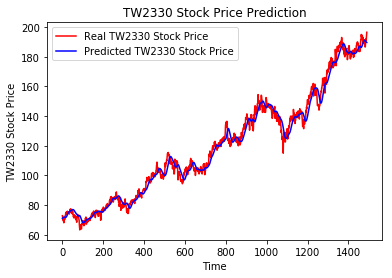

In [117]:
import matplotlib.pyplot as plt
plt.plot(real_stock_price[60:], color = 'red', label = 'Real TW2330 Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted TW2330 Stock Price')
plt.title('TW2330 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TW2330 Stock Price')
plt.legend()
plt.show()